Notebook for building analysis of resulting synapse distribution

In [1]:
import os
import sys
sys.path.append("../")
sys.path.append("../Modules/")
import pandas as pd
import h5py

from Modules import analysis

In [2]:
# presently using ben synapses
sim_directory = '/home/drfrbc/Neural-Modeling/scripts/2024-12-23-15-23-44-BenSynapses_final_detailed_syn_dist_analysis/Complex_InhGmaxApic7.1_InhGmaxDend0.0016_SomaGmax0.0025_ExcGmax-1.0351_Np1000'

# Ziao synapses: "/home/drfrbc/Neural-Modeling/scripts/2024-12-17-16-16-39-ZiaoSynapses_final_detailed_syn_dist_analysis/Complex_InhGmaxApic204_InhGmaxDend7.0_SomaGmax6.0_ExcGmax-1.0351_Np1000"

functions for loading data

In [3]:
# read synapse_data.h5 from our simulations.
def read_synapse_distribution_file(sim_directory):
    """
    Reads the synapse_data.h5 file and loads its datasets into a Pandas DataFrame.

    Parameters:
        sim_directory (str): Path to the directory containing synapse_data.h5.

    Returns:
        pd.DataFrame: A DataFrame where each column corresponds to a dataset in the HDF5 file.
    """
    # Construct the full file path
    synapse_file_path = os.path.join(sim_directory, 'synapse_data.h5')

    # Check if the file exists
    if not os.path.exists(synapse_file_path):
        raise FileNotFoundError(f"File not found: {synapse_file_path}")

    # Dictionary to temporarily store the data
    synapse_data = {}

    # Read the HDF5 file
    with h5py.File(synapse_file_path, 'r') as h5f:
        # Load all datasets into the dictionary
        for key in h5f.keys():
            synapse_data[key] = h5f[key][()]  # Load dataset into memory as NumPy array

    # Convert the dictionary into a Pandas DataFrame
    synapse_df = pd.DataFrame(synapse_data)

    return synapse_df

def read_transfer_impedance_file(sim_directory, loc='soma'):
    # loc can be nexus
    imp_file = os.path.join(sim_directory, f"elec_distance_{loc}.csv")
    impedance_data = pd.read_csv(imp_file)
    return impedance_data

def process_bens_syn_data(seg_data, connections_path="/home/drfrbc/Neural-Modeling/scripts/L5BaselineResults/Connections.csv", spike_inputs_files = [
        '/home/drfrbc/Neural-Modeling/scripts/L5BaselineResults/prox_inh_stim_spikes2.h5',
        '/home/drfrbc/Neural-Modeling/scripts/L5BaselineResults/dist_inh_stim_spikes2.h5',
        '/home/drfrbc/Neural-Modeling/scripts/L5BaselineResults/exc_stim_spikes2.h5'
    ]):
    bens_syn_data = pd.read_csv(connections_path)
    # Extract `seg_id` and `section` from the `Name` field
    seg_mapping = seg_data['seg'].reset_index().set_index('seg')['index']
    seg_data_indexed = seg_data.set_index('Unnamed: 0')
    # Map the segment names in ben_syn_data['Name'] to their indices in seg_data
    # Replace 'soma' with the desired value
    bens_syn_data['Name'] = bens_syn_data['Name'].apply(lambda x: 'L5PCtemplate[0].soma[0](0.5)' if x == 'soma' else x) # indicate that all soma synapses are on this 1 segment since our seg_data has only 1 soma segment
    bens_syn_data['seg_id'] = bens_syn_data['Name'].map(seg_mapping)
    bens_syn_data['soma_trans_imp'] = bens_syn_data['seg_id'].map(seg_data_indexed['soma_trans_imp'])
    # ben_syn_data['seg_id'] = ben_syn_data['Name'].str.extract(r'\[(\d+)\]').astype(int)
    bens_syn_data['section'] = bens_syn_data['Type']

    # # Inspect the structure of the HDF5 file
    # for file_path in file_paths:
    #     try:
    #         with h5py.File(file_path, 'r') as h5f:
    #             print(f"\nStructure of {file_path}:")
    #             h5f.visit(lambda name: print(name))
    #     except Exception as e:
    #         print(f"Error inspecting {file_path}: {e}")

    # Dictionary to store DataFrames
    bens_spike_input_data = {}

    for file_path in spike_inputs_files:
        try:
            with h5py.File(file_path, 'r') as h5f:
                print(f"\nProcessing {file_path}:")
                
                # Extract all stimulation types
                for stim_type in h5f['spikes'].keys():
                    stim_group = h5f[f'spikes/{stim_type}']
                    
                    # Load node_ids and timestamps
                    node_ids = stim_group['node_ids'][()]
                    timestamps = stim_group['timestamps'][()]
                    
                    # Combine into a DataFrame
                    df = pd.DataFrame({
                        'node_id': node_ids,
                        'timestamp': timestamps
                    })
                    
                    # Store DataFrame with a meaningful key
                    key = f"{file_path}/{stim_type}"
                    bens_spike_input_data[key] = df
                    print(f"Loaded {key} with {len(df)} rows.")

        except Exception as e:
            print(f"Error reading {file_path}: {e}")

    # # Display the DataFrames
    # for key, df in bens_spike_input_data.items():
    #     print(f"\nData from {key}:")
    #     print(df.head())

    # Calculate mean firing rates
    firing_rates = []
    for filename, df in bens_spike_input_data.items():
        mean_rates = df.groupby('node_id')['timestamp'].count() / df['timestamp'].max() * 1000
        mean_rates = mean_rates.reset_index().rename(columns={'timestamp': 'mean_firing_rate'})
        mean_rates['synapse_type'] = filename.rsplit('/', 1)[-1]
        firing_rates.append(mean_rates)

    # Combine firing rates into a single DataFrame
    firing_rates_df = pd.concat(firing_rates)

    # Merge Ben's data with firing rates
    bens_syn_data = pd.merge(
        bens_syn_data, 
        firing_rates_df, 
        left_on='Node ID', 
        right_on='node_id', 
        how='left'
    )

    # Add PC Name (example format)
    bens_syn_data['pc_name'] = 'b' + bens_syn_data['Node ID'].astype(str)

    # Rename columns to match desired format
    bens_syn_data = bens_syn_data.rename(columns={
        # 'Node ID': 'seg_id',
        'Conductance': 'weight'
    })

    # Reorder and select relevant columns
    bens_syn_data = bens_syn_data[['mean_firing_rate', 'pc_name', 'seg_id', 'synapse_type', 
                            'weight', 'Distance', 'section', "soma_trans_imp"]]
    
    return bens_syn_data

def add_seg_info_to_syn_data(syn_data, seg_data):
    """
    Adds segment information (Distance and section) from seg_data to syn_data
    using the seg_id as a lookup.

    Parameters:
        syn_data (pd.DataFrame): DataFrame containing synapse data with 'seg_id'.
        seg_data (pd.DataFrame): DataFrame containing segment data.

    Returns:
        pd.DataFrame: Updated syn_data with 'Distance' and 'section' columns added.
    """
    # Set 'Unnamed: 0' as the index in seg_data for easy lookup
    seg_data_indexed = seg_data.set_index('Unnamed: 0')

    # Use .loc to map the segment information to syn_data based on seg_id
    syn_data['Distance'] = syn_data['seg_id'].map(seg_data_indexed['Distance'])
    syn_data['section'] = syn_data['seg_id'].map(seg_data_indexed['section'])
    syn_data['soma_trans_imp'] = syn_data['seg_id'].map(seg_data_indexed['soma_trans_imp'])

    # Convert the 'synapse_type' column from bytes to strings
    syn_data['synapse_type'] = syn_data['synapse_type'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

    return syn_data

## Load data

In [4]:
# read synapses from our simulation and ben's
syn_data = read_synapse_distribution_file(sim_directory)

# read segment data from our simulation
seg_data = pd.read_csv(os.path.join(sim_directory, "segment_data.csv"))

# read transfer impedances
imp_df = read_transfer_impedance_file(sim_directory, loc='soma')
seg_data['soma_trans_imp'] = imp_df.beta_active

# add segment information of synapse location
syn_data = add_seg_info_to_syn_data(syn_data, seg_data)

# read ben's synapse data and add seg info
bens_syn_data = process_bens_syn_data(seg_data, connections_path="/home/drfrbc/Neural-Modeling/scripts/L5BaselineResults/Connections.csv", spike_inputs_files = [
        '/home/drfrbc/Neural-Modeling/scripts/L5BaselineResults/prox_inh_stim_spikes2.h5',
        '/home/drfrbc/Neural-Modeling/scripts/L5BaselineResults/dist_inh_stim_spikes2.h5',
        '/home/drfrbc/Neural-Modeling/scripts/L5BaselineResults/exc_stim_spikes2.h5'
    ])

# read voltages, currents?

# read parameters from our simulation (not used right now)
# parameters = analysis.DataReader.load_parameters(sim_directory)



Processing /home/drfrbc/Neural-Modeling/scripts/L5BaselineResults/prox_inh_stim_spikes2.h5:
Loaded /home/drfrbc/Neural-Modeling/scripts/L5BaselineResults/prox_inh_stim_spikes2.h5/prox_inh_stim with 343821 rows.

Processing /home/drfrbc/Neural-Modeling/scripts/L5BaselineResults/dist_inh_stim_spikes2.h5:
Loaded /home/drfrbc/Neural-Modeling/scripts/L5BaselineResults/dist_inh_stim_spikes2.h5/dist_inh_stim with 614347 rows.

Processing /home/drfrbc/Neural-Modeling/scripts/L5BaselineResults/exc_stim_spikes2.h5:
Loaded /home/drfrbc/Neural-Modeling/scripts/L5BaselineResults/exc_stim_spikes2.h5/exc_stim with 5251338 rows.


In [5]:
seg_data['soma_trans_imp'] = imp_df.beta_active

In [6]:
if len(seg_data) != len(imp_df):
    IndexError(f"{len(seg_data)} != {max(syn_data.seg_id)}. The imp_df does not correspond to seg_data")

In [7]:
if len(seg_data) != max(syn_data.seg_id):
    print(f"{len(seg_data)} != {max(syn_data.seg_id)} need to check that syn_data.seg_id actually corresponds to seg_data row index.")

2511 != 2507 need to check that syn_data.seg_id actually corresponds to seg_data row index.


functions for organizing data

## Plotting, group by synapse type

In [8]:
import numpy as np
# syn_data['soma_trans_imp_adjusted'] = -np.log(1-syn_data['soma_trans_imp'])
# bens_syn_data['soma_trans_imp_adjusted'] = -np.log(1-bens_syn_data['soma_trans_imp'])
# syn_data['soma_trans_imp_adjusted'][syn_data['soma_trans_imp_adjusted']==np.inf] = 0
# bens_syn_data['soma_trans_imp_adjusted'][bens_syn_data['soma_trans_imp_adjusted']==np.inf] = 0

syn_data['soma_trans_imp_adjusted'] = -np.log(syn_data['soma_trans_imp'])
bens_syn_data['soma_trans_imp_adjusted'] = -np.log(bens_syn_data['soma_trans_imp'])

# Group the data by 'synapse_type'
syn_data_grouped_by_type = syn_data.groupby('synapse_type')
bens_syn_data_grouped_by_type = bens_syn_data.groupby('synapse_type')

In [9]:
syn_data['soma_trans_imp_adjusted']

0       -0.000000
1       -0.000000
2       -0.000000
3       -0.000000
4       -0.000000
           ...   
29194    0.545131
29195    2.462941
29196    5.381510
29197    1.465728
29198    3.840810
Name: soma_trans_imp_adjusted, Length: 29199, dtype: float64

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_by_group(x_var, y_var, syn_data_grouped_by_type):
    plt.figure(figsize=(10, 6))
    # Iterate through each group and plot
    for syn_type, group in syn_data_grouped_by_type:
        plt.scatter(group[x_var], group[y_var], label=syn_type, alpha=0.7)
    # Add plot details
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.title(f'{y_var} vs {x_var} by Synapse Type')
    plt.legend(title='Synapse Type')
    plt.grid(True)
    # Show the plot
    plt.show()

def plot_2d_pdf_by_group(x_var, y_var, syn_data_grouped_by_type):
    """
    Plots the 2D probability density function for specified X and Y variables, grouped by synapse type.
    The legend is manually constructed to ensure it displays all groups correctly.

    Parameters:
        x_var (str): The variable to use for the X-axis (e.g., 'Distance').
        y_var (str): The variable to use for the Y-axis (e.g., 'mean_firing_rate').
        syn_data_grouped_by_type (GroupBy object): The grouped data (e.g., grouped by 'synapse_type').
    """
    plt.figure(figsize=(10, 6))

    # Define a color palette for the groups
    palette = sns.color_palette("husl", len(syn_data_grouped_by_type))
    colors = iter(palette)

    # Dummy handles for the legend
    legend_handles = []

    # Plot each group with a unique color
    for syn_type, group in syn_data_grouped_by_type:
        color = next(colors)
        sns.kdeplot(
            x=group[x_var],
            y=group[y_var],
            fill=True,
            alpha=0.3,
            color=color
        )
        # Add a dummy handle for the legend
        legend_handles.append(plt.Line2D([0], [0], color=color, lw=4, label=syn_type))

    # Add plot details
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.title(f'2D Probability Density of {y_var} vs {x_var} by Synapse Type')
    plt.legend(handles=legend_handles, title='Synapse Type', loc='best')
    plt.grid(True)
    # Show the plot
    plt.show()

plot firing rate as a function of distance

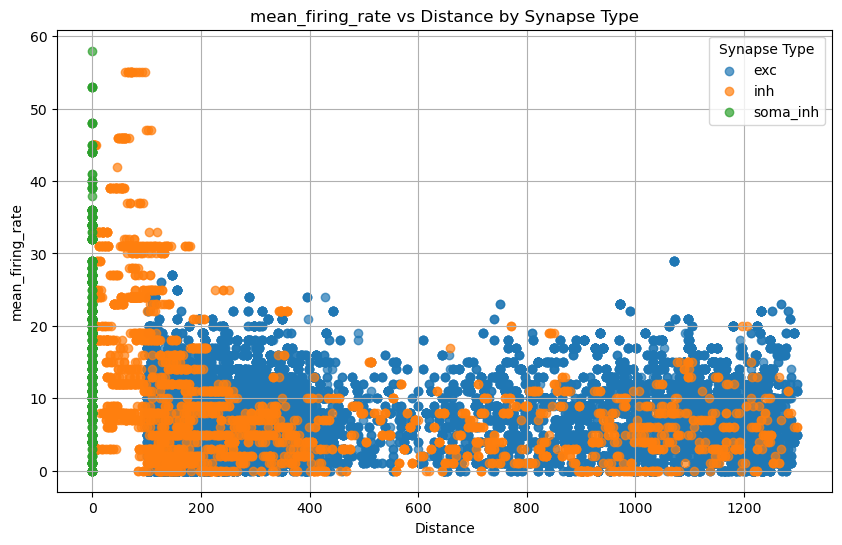

In [11]:
# plt.scatter(syn_data.Distance, syn_data.mean_firing_rate)

plot_by_group(x_var='Distance', y_var='mean_firing_rate', syn_data_grouped_by_type=syn_data_grouped_by_type)

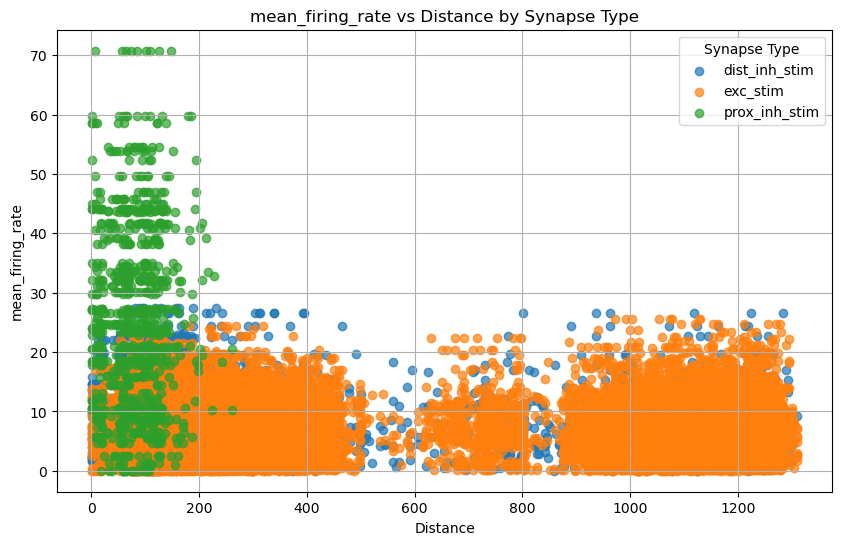

In [12]:
plot_by_group(x_var='Distance', y_var='mean_firing_rate', syn_data_grouped_by_type=bens_syn_data_grouped_by_type)

/tmp/ipykernel_4150390/3947618534.py:40: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


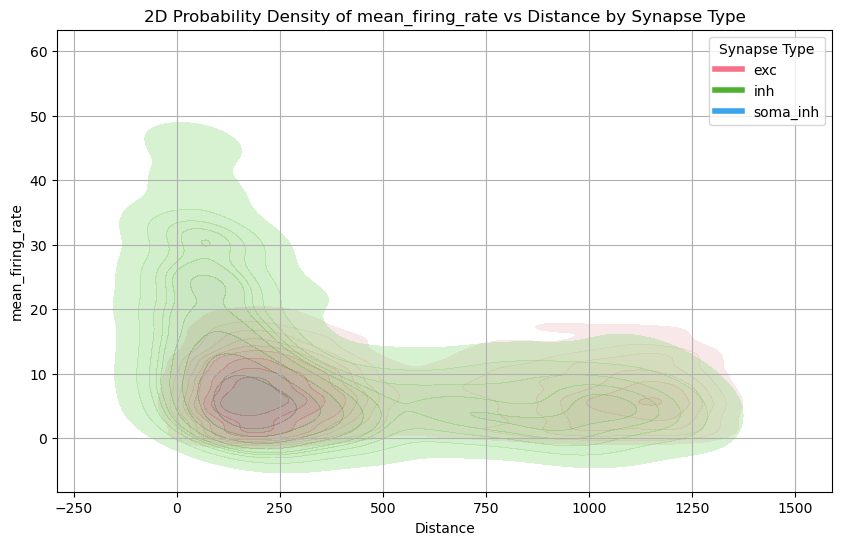

In [13]:
plot_2d_pdf_by_group(x_var='Distance', y_var='mean_firing_rate', syn_data_grouped_by_type=syn_data_grouped_by_type)

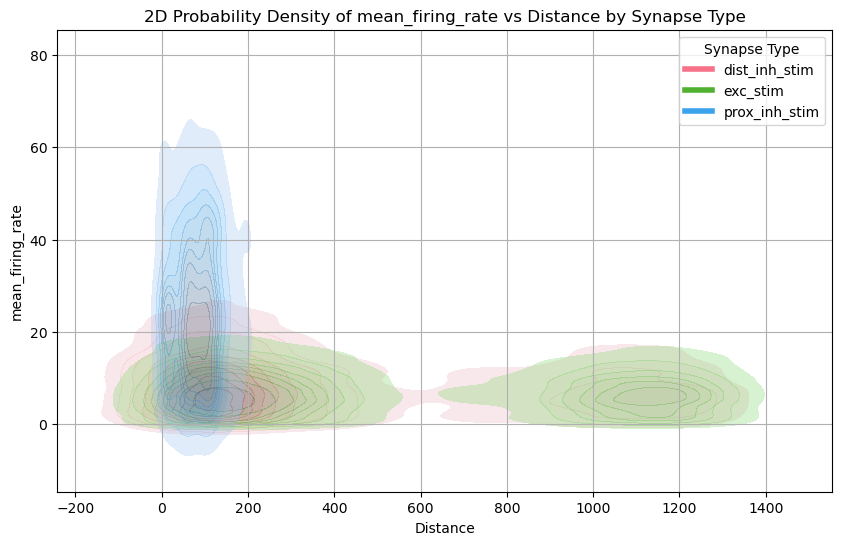

In [14]:
plot_2d_pdf_by_group(x_var='Distance', y_var='mean_firing_rate', syn_data_grouped_by_type=bens_syn_data_grouped_by_type)

weight as a function of Distance

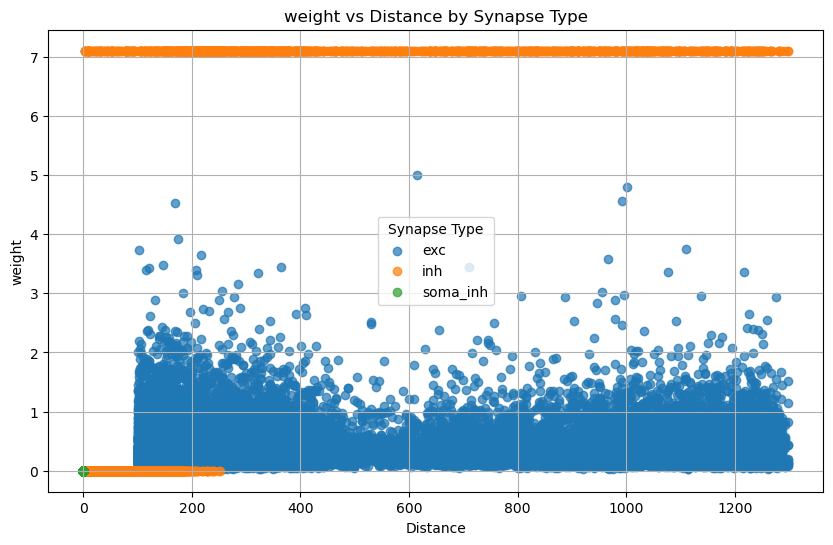

In [15]:
plot_by_group(x_var='Distance', y_var='weight', syn_data_grouped_by_type=syn_data_grouped_by_type)

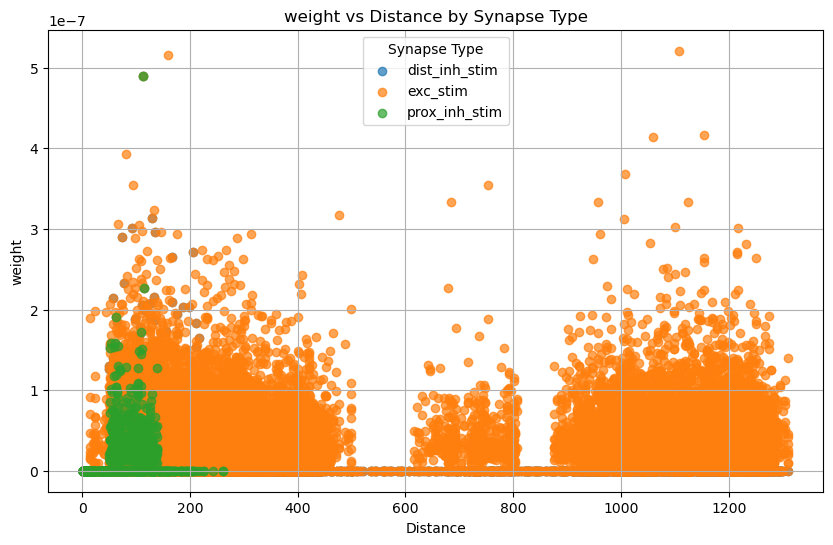

In [16]:
plot_by_group(x_var='Distance', y_var='weight', syn_data_grouped_by_type=bens_syn_data_grouped_by_type)

/tmp/ipykernel_4150390/3947618534.py:40: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


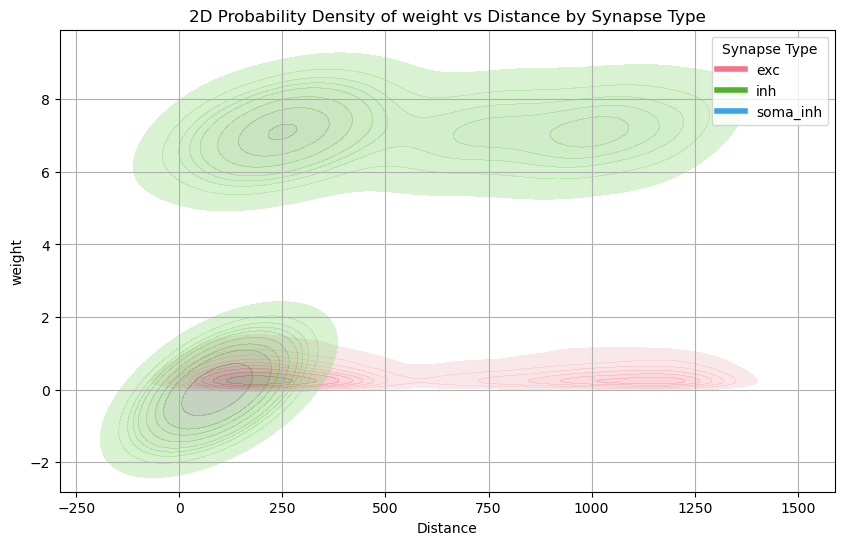

In [17]:
plot_2d_pdf_by_group(x_var='Distance', y_var='weight', syn_data_grouped_by_type=syn_data_grouped_by_type)

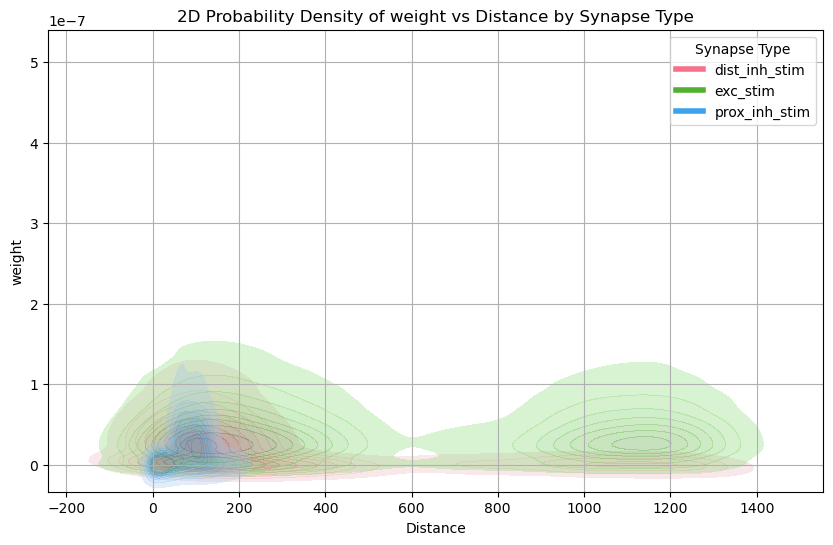

In [18]:
plot_2d_pdf_by_group(x_var='Distance', y_var='weight', syn_data_grouped_by_type=bens_syn_data_grouped_by_type)

Now plot them together

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns


def compare_plot_by_group_subplots(x_var, y_var, syn_data_grouped_by_type, bens_syn_data_grouped_by_type):
    """
    Compare two datasets by plotting grouped data into separate subplots based on 'inh' or 'exc' in the synapse type.

    Parameters:
        x_var (str): The variable to use for the X-axis (e.g., 'Distance').
        y_var (str): The variable to use for the Y-axis (e.g., 'mean_firing_rate').
        syn_data_grouped_by_type (iterable): The grouped data for the first dataset.
        bens_syn_data_grouped_by_type (iterable): The grouped data for Ben's dataset.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
    titles = ['Inhibitory Synapses', 'Excitatory Synapses']

    # Define markers and colors
    markers = ['o', '^', 's', 'D']  # Markers for Ben's data
    syn_data_color = 'tab:blue'  # Blue for syn_data
    bens_data_color = 'tab:red'  # Red for Ben's data

    # Function to ensure string comparison for bytes-like synapse types
    def is_substring_in_syn_type(syn_type, keyword):
        return keyword in syn_type.decode() if isinstance(syn_type, bytes) else keyword in syn_type

    # Subplot 1: 'inh' synapses
    ax_inh = axes[0]
    for (syn_type, group) in syn_data_grouped_by_type:
        if is_substring_in_syn_type(syn_type, 'inh'):
            ax_inh.scatter(group[x_var], group[y_var], label=f'{syn_type} (syn_data)', alpha=0.7, color=syn_data_color, marker='o')
    for (syn_type, group), marker in zip(bens_syn_data_grouped_by_type, markers):
        if is_substring_in_syn_type(syn_type, 'inh'):
            ax_inh.scatter(group[x_var], group[y_var], label=f'{syn_type} (Ben\'s data)', alpha=0.7, color=bens_data_color, marker=marker)
    ax_inh.set_title(titles[0])
    ax_inh.set_xlabel(x_var)
    ax_inh.set_ylabel(y_var)
    ax_inh.legend()
    ax_inh.grid(True)

    # Subplot 2: 'exc' synapses
    ax_exc = axes[1]
    for (syn_type, group) in syn_data_grouped_by_type:
        if is_substring_in_syn_type(syn_type, 'exc'):
            ax_exc.scatter(group[x_var], group[y_var], label=f'{syn_type} (syn_data)', alpha=0.7, color=syn_data_color, marker='o')
    for (syn_type, group), marker in zip(bens_syn_data_grouped_by_type, markers):
        if is_substring_in_syn_type(syn_type, 'exc'):
            ax_exc.scatter(group[x_var], group[y_var], label=f'{syn_type} (Ben\'s data)', alpha=0.7, color=bens_data_color, marker=marker)
    ax_exc.set_title(titles[1])
    ax_exc.set_xlabel(x_var)
    ax_exc.grid(True)
    ax_exc.legend()

    # Adjust layout and show
    plt.tight_layout()
    plt.show()

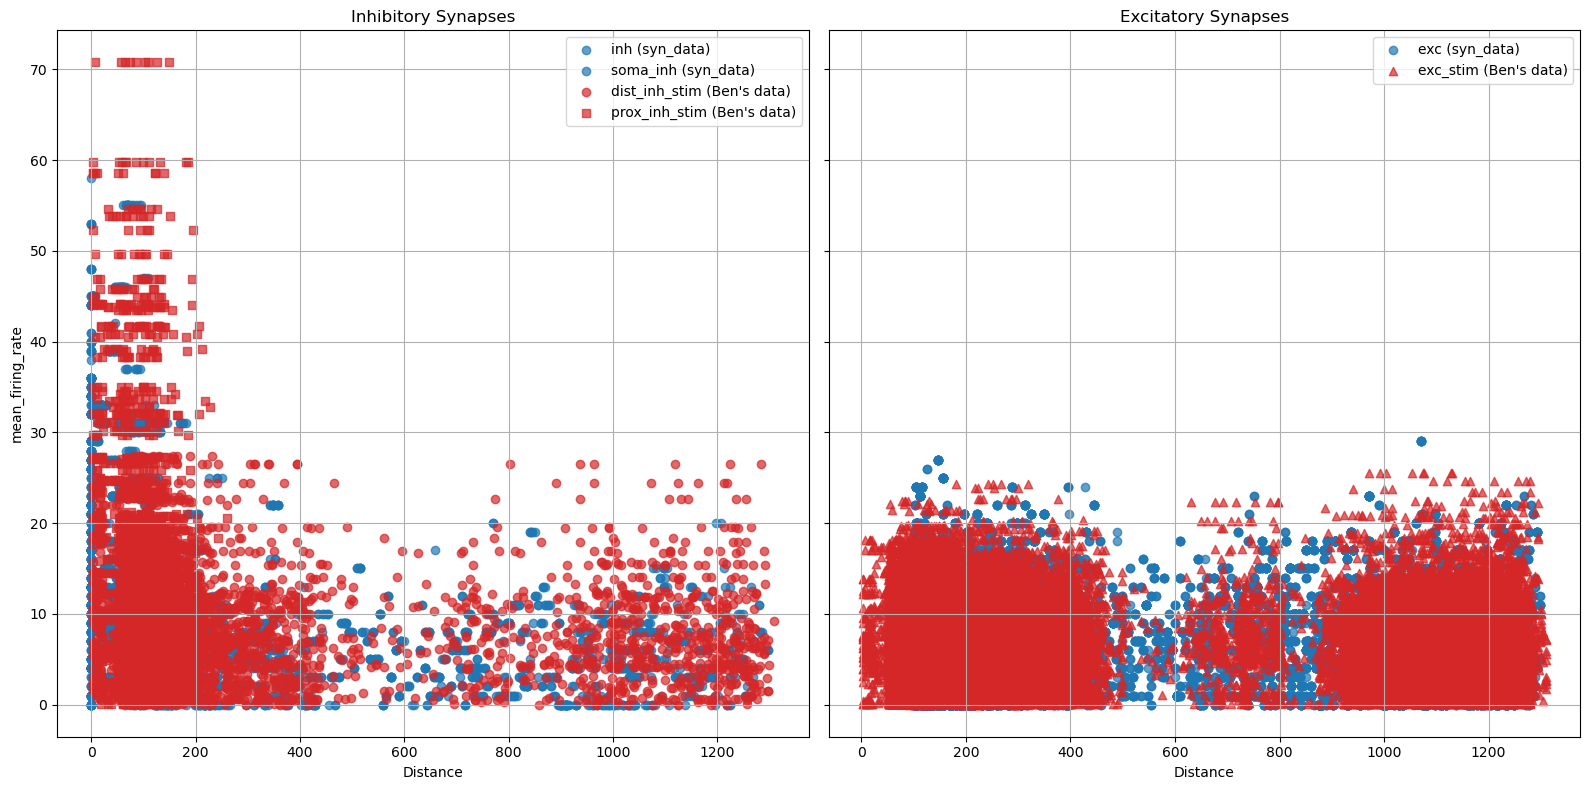

In [20]:
compare_plot_by_group_subplots(
    x_var='Distance',
    y_var='mean_firing_rate',
    syn_data_grouped_by_type=syn_data_grouped_by_type,
    bens_syn_data_grouped_by_type=bens_syn_data_grouped_by_type
)

In [21]:
max(syn_data.weight)

7.1

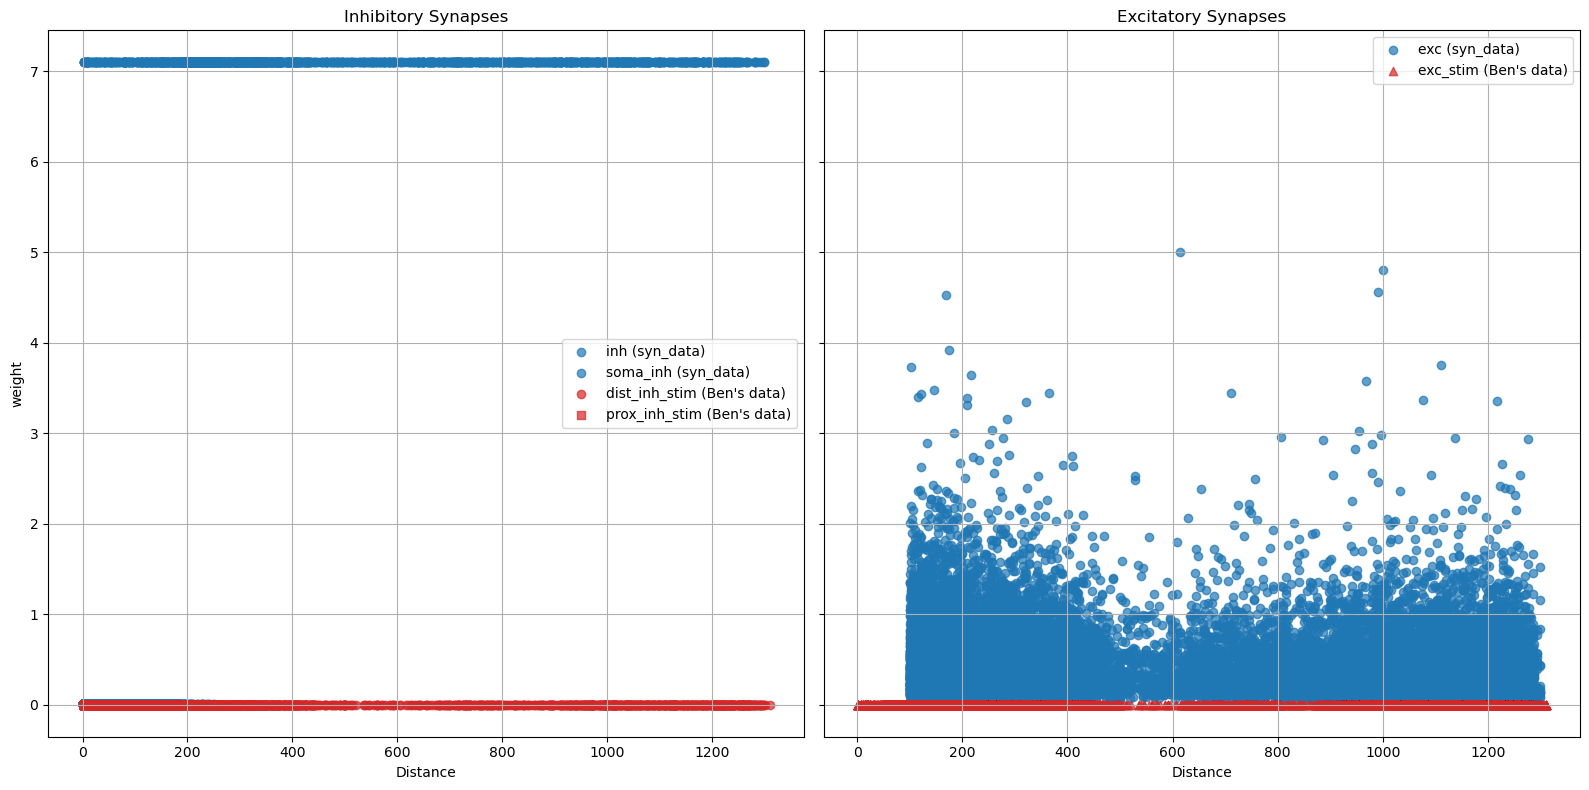

In [22]:
compare_plot_by_group_subplots(
    x_var='Distance',
    y_var='weight',
    syn_data_grouped_by_type=syn_data_grouped_by_type,
    bens_syn_data_grouped_by_type=bens_syn_data_grouped_by_type
)

## Plot synapse locations on morphology

In [23]:
# Plot morphology with synapse count coloring
from collections import Counter
def build_synapse_counts_dict(syn_data, seg_id_column):
    """
    Builds a dictionary of synapse counts for each segment ID.

    Parameters:
        syn_data (DataFrame): Data containing synapse information.
        seg_id_column (str): Column name for segment IDs.

    Returns:
        dict: A dictionary mapping segment IDs to synapse counts.
    """
    synapse_counts = Counter(syn_data[seg_id_column])
    return dict(synapse_counts)


def plot_morphology_subplots(seg_data, seg_id_column, synapse_counts_dict_bens, synapse_counts_dict_ours, elevation=20, azimuth=-100, radius_scale=1.0, title_prefix = '', clim_max = 30):
    """
    Plots two subplots of morphology segments: one for Ben's data and one for our data, colored based on synapse counts.

    Parameters:
        seg_data (DataFrame): Data containing segment positions and radii.
        seg_id_column (str): The column name for segment IDs.
        synapse_counts_dict_bens (dict): Synapse counts for Ben's data.
        synapse_counts_dict_ours (dict): Synapse counts for our data.
        elevation (int): Elevation angle for the 3D plot.
        azimuth (int): Azimuth angle for the 3D plot.
        radius_scale (float): Scaling factor for segment radius.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 8), subplot_kw={'projection': '3d'})
    titles = [f"{title_prefix} Ben's Synapse Counts", f" {title_prefix} Our Synapse Counts"]
    synapse_counts_dicts = [synapse_counts_dict_bens, synapse_counts_dict_ours]

    custom_vmin = 0       # Replace with your manual minimum limit
    custom_vmax = clim_max     # Replace with your manual maximum limit
    norm = plt.Normalize(vmin=custom_vmin, vmax=custom_vmax)

    for ax, title, synapse_counts in zip(axes, titles, synapse_counts_dicts):
        # max_count = max(synapse_counts.values()) if synapse_counts else 1
        for seg_id, seg in seg_data.iterrows():
            if seg_id != 0:
                x_points = [seg['p0_0'], seg['pc_0'], seg['p1_0']]
                y_points = [seg['p0_1'], seg['pc_1'], seg['p1_1']]
                z_points = [seg['p0_2'], seg['pc_2'], seg['p1_2']]

                radius = seg['r'] * radius_scale
                count = synapse_counts.get(seg_id, 0)
                # color = plt.cm.viridis(count / max_count)  # Color based on normalized count
                color = plt.cm.viridis(norm(count))  # Apply normalization to the color


                ax.plot(x_points, z_points, y_points, linewidth=radius, color=color)
        ax.set_title(title)
        ax.view_init(elev=elevation, azim=azimuth)
        ax.set_xlabel('X')
        ax.set_ylabel('Z')
        ax.set_zlabel('Y')

    # Fix colorbar for global scaling
    # mappable = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=max([max(synapse_counts_dict_bens.values()), max(synapse_counts_dict_ours.values())])))
    # plt.colorbar(mappable, ax=axes, shrink=0.6, label='Synapse Count')
    mappable = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
    plt.colorbar(mappable, ax=axes, shrink=0.6, label='Synapse Count')
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_4150390/2629823020.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


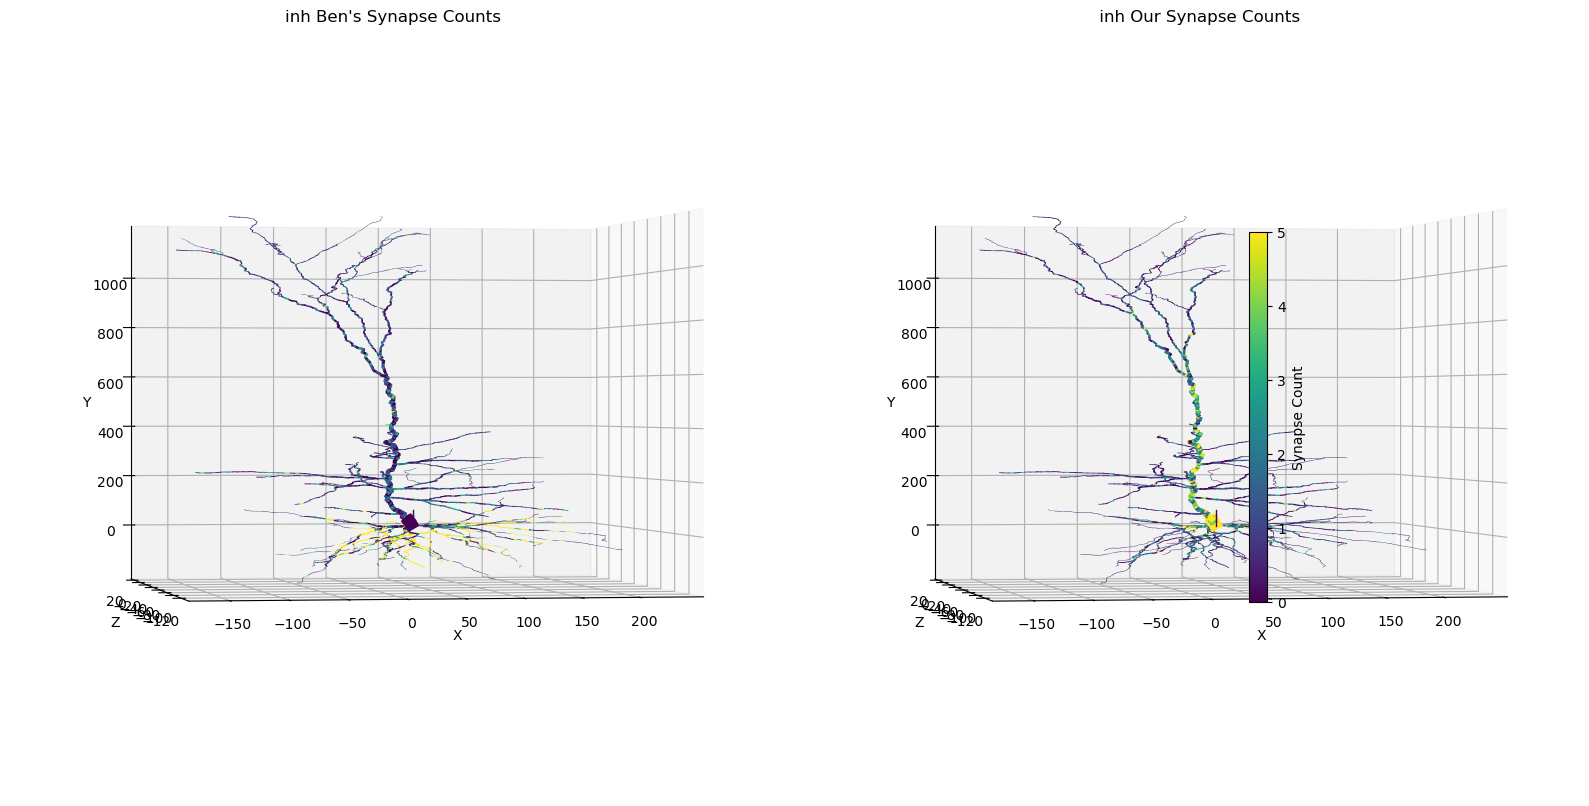

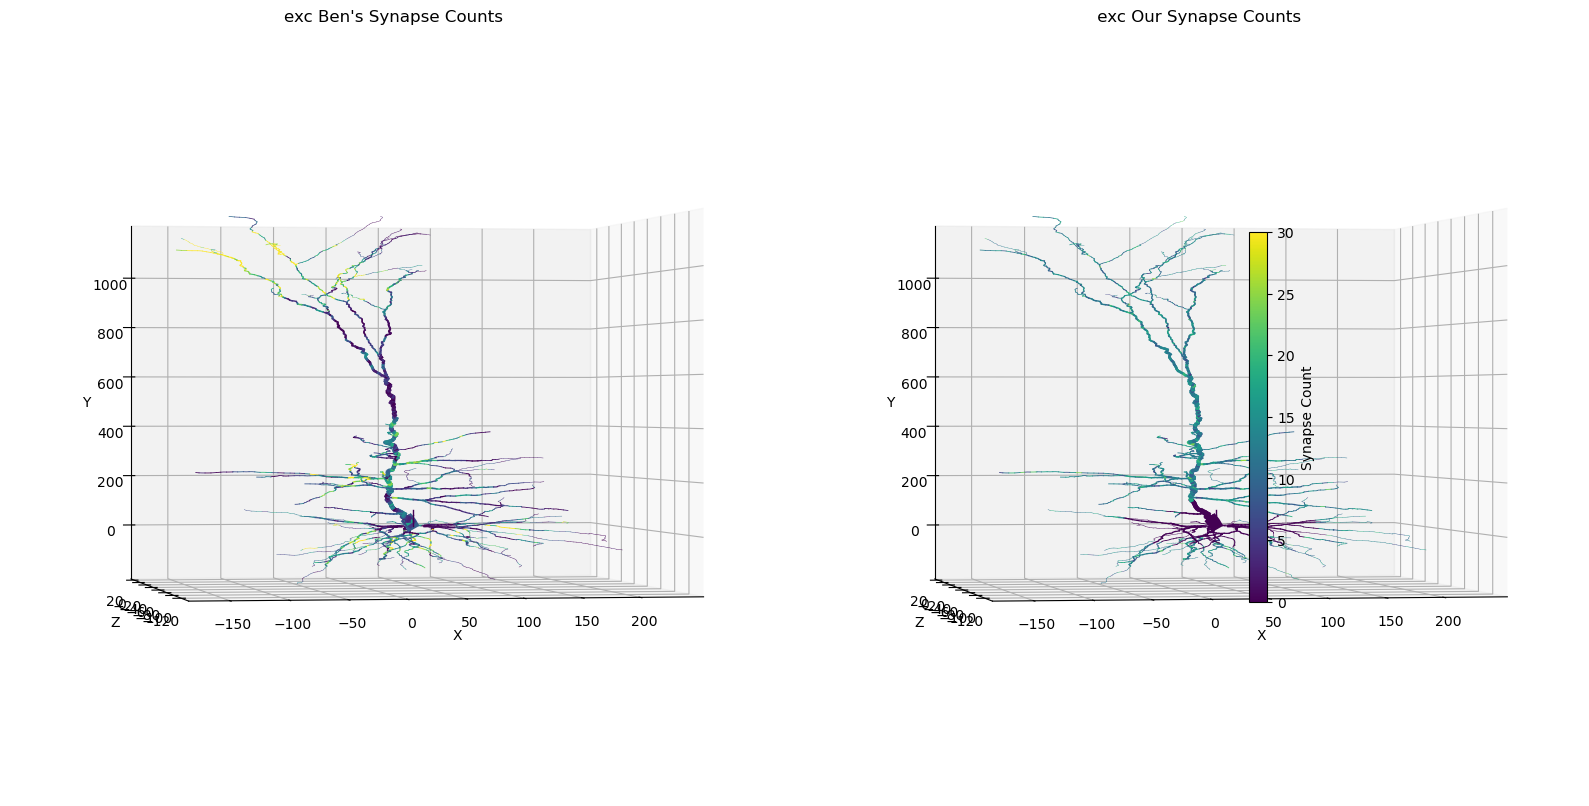

In [24]:
clim_maxes = [5, 30]
for i,syn_type in enumerate(['inh', 'exc']):

    bens_syn_data_by_this_syntype = bens_syn_data[bens_syn_data['synapse_type'].str.contains(syn_type, na=False)]
    ours_syn_data_by_this_syntype = syn_data[syn_data['synapse_type'].str.contains(syn_type, na=False)]

    synapse_counts_bens = build_synapse_counts_dict(bens_syn_data_by_this_syntype, seg_id_column='seg_id')
    synapse_counts_ours = build_synapse_counts_dict(ours_syn_data_by_this_syntype, seg_id_column='seg_id')
    # synapse_counts_bens.pop(0) # remove soma segment since it has way more synapses 
    # synapse_counts_ours.pop(0) # remove soma segment since it has way more synapses 
    plot_morphology_subplots(seg_data, seg_id_column='seg_id', synapse_counts_dict_bens=synapse_counts_bens, synapse_counts_dict_ours=synapse_counts_ours, radius_scale = 2.0, 
                             azimuth=-100, elevation = 0, title_prefix = syn_type, clim_max = clim_maxes[i])

## plot firing rate as a function of transfer impedance (*the transfer impendance ratio cannot be less than 0 so the pdfs are kind of BS)

In [25]:
syn_data['soma_trans_imp'][syn_data['soma_trans_imp'] < 0]

Series([], Name: soma_trans_imp, dtype: float64)

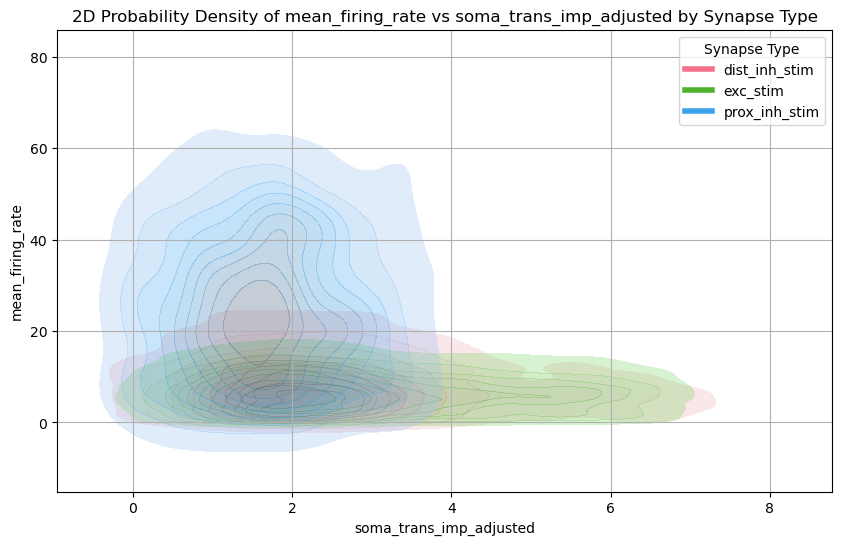

In [26]:
plot_2d_pdf_by_group(x_var='soma_trans_imp_adjusted', y_var='mean_firing_rate', syn_data_grouped_by_type=bens_syn_data_grouped_by_type)

/tmp/ipykernel_4150390/3947618534.py:40: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


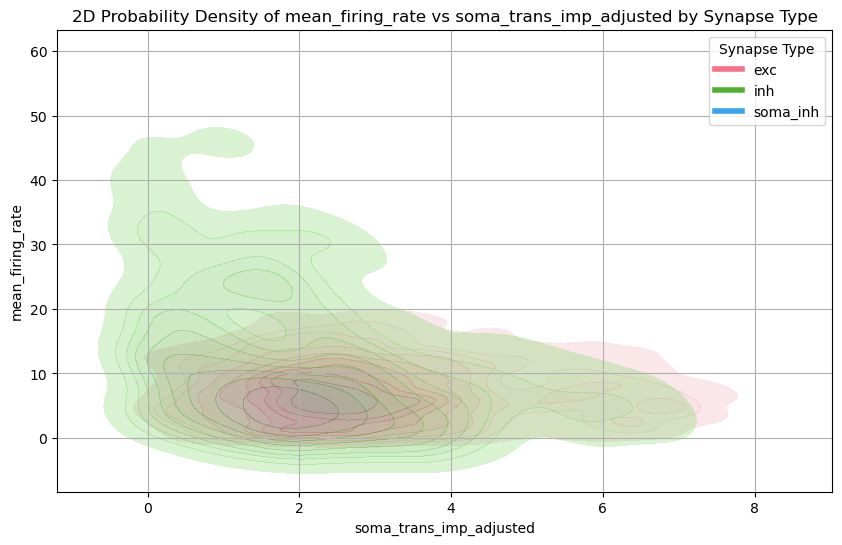

In [27]:
plot_2d_pdf_by_group(x_var='soma_trans_imp_adjusted', y_var='mean_firing_rate', syn_data_grouped_by_type=syn_data_grouped_by_type)

plot mean segment firing rate over morphology

plot weight as a function of transfer impedance?

plot cumulative in-path gmax as a function of transfer impedance?

In [ ]:
from Modules import cell_model